<a href="https://colab.research.google.com/github/ifeomamegwai/Renewable-Energy-Predictive-Analysis-2/blob/main/Renewable_Energy_Worldwide_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.2 Regression Analysis:

An analysis to predicts how changes in entities renewable energy capacity (hydro, wind, solar, geothermal) affect the reduction in fossil fuel usage, aiming to quantify the relationship between renewable energy growth and decreased fossil fuel reliance.



Four distinct models Linear Regression, Random Forest, Gradient Boosting and XGBoost were employed in the effort to get the best model fit for the analysis


IMPORT THE LIBRARIES AND DATA

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor

In [38]:
project_id = "renewableenergy-434508"
dataset = "RWE"
table = "global_hydro_wind_solar_geothermal_view"
query = f"SELECT * FROM `{project_id}.{dataset}.{table}`"

df = pd.read_gbq(query, project_id=project_id)


In [39]:
df.shape

(1743, 7)

In [40]:
df.isnull().sum()

,0
entity,0
year,0
electricity_from_fossil_fuels_TWh,0
hydro_equ_primary_energy,231
wind_capacity,882
solar_capacity,840
geothermal_capacity,1260


**PREPROCESSING**

**obtain the minimum value for each column**

In [41]:
df[df['electricity_from_fossil_fuels_TWh']!=0].min()

,0
entity,Algeria
year,2000
electricity_from_fossil_fuels_TWh,0.01
hydro_equ_primary_energy,0.0
wind_capacity,0.0
solar_capacity,0.0
geothermal_capacity,0.0


In [42]:
df[df['hydro_equ_primary_energy']!=0].min()

,0
entity,Algeria
year,2000
electricity_from_fossil_fuels_TWh,0.0
hydro_equ_primary_energy,0.01
wind_capacity,0.0
solar_capacity,0.0
geothermal_capacity,0.0


In [43]:
df[df['solar_capacity']!=0].min()

,0
entity,Algeria
year,2000
electricity_from_fossil_fuels_TWh,0.0
hydro_equ_primary_energy,0.0
wind_capacity,0.0
solar_capacity,0.000015
geothermal_capacity,0.0


In [44]:
df[df['geothermal_capacity']!=0].min()

,0
entity,Algeria
year,2000
electricity_from_fossil_fuels_TWh,0.0
hydro_equ_primary_energy,0.0
wind_capacity,0.0
solar_capacity,0.0
geothermal_capacity,0.2


In [45]:
df[df['wind_capacity']!=0].min()

,0
entity,Algeria
year,2000
electricity_from_fossil_fuels_TWh,0.0
hydro_equ_primary_energy,0.0
wind_capacity,0.00015
solar_capacity,0.0
geothermal_capacity,0.0


**Replace the 0 in each column with the minimum value of the column for each of percent change calculation**

In [46]:
df.loc[df['electricity_from_fossil_fuels_TWh']==0, 'electricity_from_fossil_fuels_TWh']=0.01

In [47]:
df.loc[df['wind_capacity']==0, 'wind_capacity']=0.00015

In [48]:
df.loc[df['solar_capacity']==0, 'solar_capacity']=0.000015


In [49]:
df.loc[df['geothermal_capacity']== 0, 'geothermal_capacity']=0.2

In [50]:
df.loc[df['hydro_equ_primary_energy'] == 0, 'hydro_equ_primary_energy'] = 0.01

**Fill Null in targat and features with FFill**

In [51]:
df[['electricity_from_fossil_fuels_TWh','hydro_equ_primary_energy', 'wind_capacity', 'solar_capacity','geothermal_capacity']]=df[['electricity_from_fossil_fuels_TWh','hydro_equ_primary_energy', 'wind_capacity', 'solar_capacity','geothermal_capacity']].ffill(axis=1)


**Calculate the percent change of fossil fuel and renewable energies capacities per entity**

In [52]:
df['fossil_pct_change'] = df['electricity_from_fossil_fuels_TWh'].pct_change(periods=1)

In [53]:
df['hydro_pct_change'] = df['hydro_equ_primary_energy'].pct_change(periods=1, fill_method=None)

In [54]:
df['wind_pct_change'] = df['wind_capacity'].pct_change(periods=1, fill_method=None)

In [55]:
df['solar_pct_change'] = df['solar_capacity'].pct_change(periods=1, fill_method=None)

In [56]:
df['geothermal_pct_change'] = df['geothermal_capacity'].pct_change(periods=1, fill_method=None)

In [57]:
df = df[df['year'] != 2000]


**Check for possible correlation between fossil fuel usage and percentatage chande in renewables capacities**


In [58]:
corr = df[['fossil_pct_change',	'hydro_pct_change',	'wind_pct_change',	'solar_pct_change',	'geothermal_pct_change']].corr()
corr

,fossil_pct_change,hydro_pct_change,wind_pct_change,solar_pct_change,geothermal_pct_change
fossil_pct_change,1.000000,0.020404,-0.000420,0.016262,0.003333
hydro_pct_change,0.020404,1.000000,0.082966,0.017561,0.017204
wind_pct_change,-0.000420,0.082966,1.000000,0.019111,0.018966
solar_pct_change,0.016262,0.017561,0.019111,1.000000,0.992353
geothermal_pct_change,0.003333,0.017204,0.018966,0.992353,1.000000


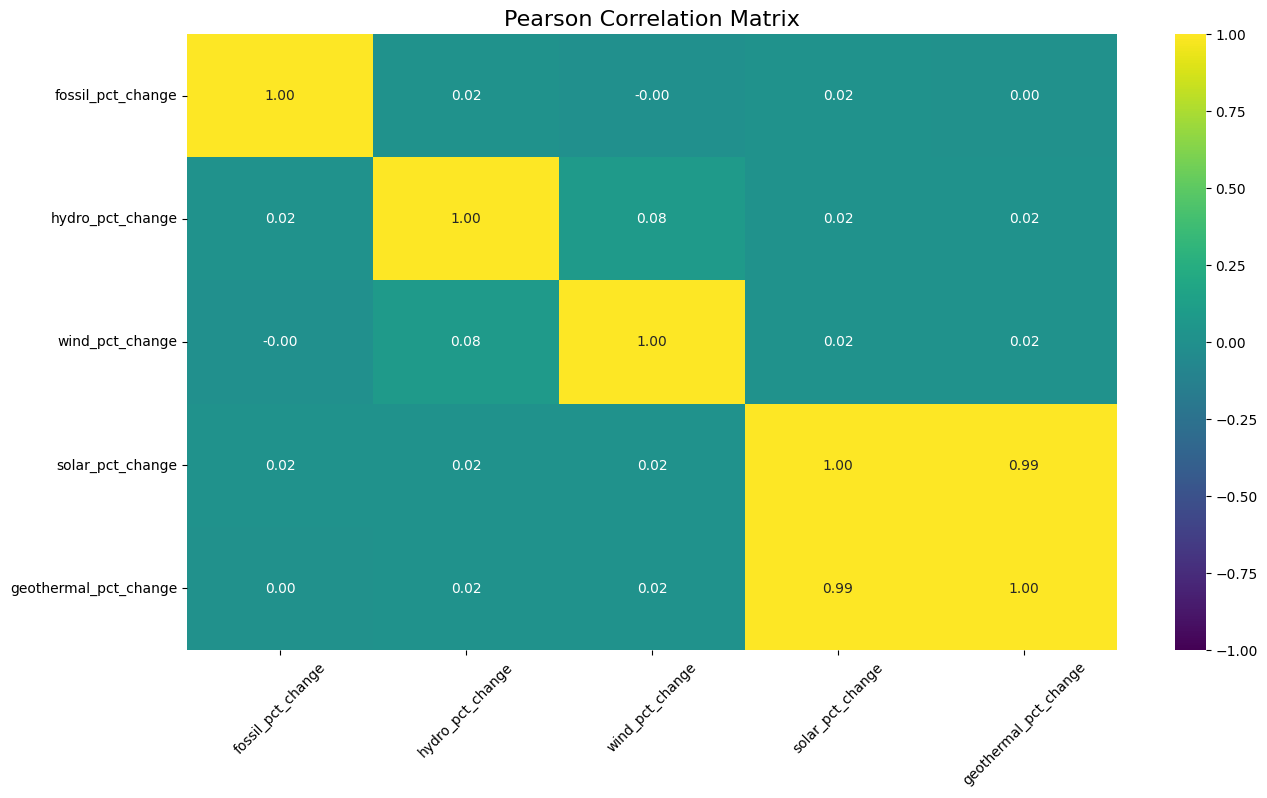

In [59]:
# visulaising the correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(corr, vmin = -1, vmax = 1,cmap = "viridis",annot = True, fmt = '.2f')
plt.title('Pearson Correlation Matrix', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

In [60]:
df.describe()

,year,electricity_from_fossil_fuels_TWh,hydro_equ_primary_energy,wind_capacity,solar_capacity,geothermal_capacity,fossil_pct_change,hydro_pct_change,wind_pct_change,solar_pct_change,geothermal_pct_change
count,1660.0,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,2010.5,145.855036,8.218500,6.604671,4.899410,126.725372,0.155037,0.044555,0.522275,3.757955,3.739405
std,5.768019,498.566570,12.354187,16.550303,13.980038,395.163640,4.036164,0.576577,6.421609,61.520568,61.577239
min,2001.0,0.010000,0.010000,0.000150,0.000015,0.000015,-0.877551,-0.998476,-0.998476,-0.809524,-0.721805
25%,2005.75,5.942500,0.530000,0.074000,0.010000,0.011501,-0.031581,-0.084690,0.000000,0.000000,0.000000
50%,2010.5,27.780000,3.125000,1.348575,0.414900,0.888297,0.020275,0.000000,0.036561,0.055016,0.000000
75%,2015.25,90.090000,10.932500,4.813731,2.790000,18.000000,0.072841,0.085050,0.208429,0.324604,0.205170
max,2020.0,5184.130000,69.280000,282.112660,253.417800,2607.000000,162.402930,16.538462,219.000000,2026.333333,2026.333333


**Features and Target selection: First models training with Entity included as feature**

In [61]:
#Define Features and Target
X= df[['entity', 'hydro_pct_change', 'wind_pct_change', 'solar_pct_change', 'geothermal_pct_change']]
y= df['fossil_pct_change']

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1328, 5), (332, 5), (1328,), (332,))

In [64]:
# Scale numeric features
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [65]:
# Convert scaled arrays back into DataFrames

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns)

In [66]:
#Encode categorical 'entity' feature
X_test_cat = X_test.select_dtypes(exclude='number')
X_train_cat = X_train.select_dtypes(exclude='number')

# Instanciate One hot encoder
ohe = OneHotEncoder(sparse_output = False)

# fit on all the X set because some data could miss in the train and appear in the test
X_cat = X.select_dtypes(exclude='number')
ohe.fit(X_cat)

 # transform train and test set
X_train_cat = pd.DataFrame(ohe.transform(X_train_cat), columns=ohe.get_feature_names_out())
X_test_cat = pd.DataFrame(ohe.transform(X_test_cat), columns=ohe.get_feature_names_out())



In [67]:
#concatenate the numeric and non-numeric normalized columns together
X_train_preproc = pd.concat((X_train_cat, X_train_scaled), axis=1)
X_test_preproc = pd.concat((X_test_cat, X_test_scaled), axis=1)

**Instantiate, fit and evaluate four models**

In [68]:
# Function to evaluate models using 4 distinct models: Linear Regression, Random Forest, Gradient Boosting, and XGBoost
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Linear Regression
model_linear = LinearRegression()
mse_linear, mae_linear, r2_linear = evaluate_model(model_linear, X_train_preproc, X_test_preproc, y_train, y_test)

# Random Forest
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
mse_rf, mae_rf, r2_rf = evaluate_model(model_rf, X_train_preproc, X_test_preproc, y_train, y_test)

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=50, random_state=42)
mse_gb, mae_gb, r2_gb = evaluate_model(model_gb, X_train_preproc, X_test_preproc, y_train, y_test)

# XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
mse_xgb, mae_xgb, r2_xgb = evaluate_model(model_xgb, X_train_preproc, X_test_preproc, y_train, y_test)

# Output the results for all 4 models
print(f"Linear Regression - MSE: {mse_linear:.4f}, MAE: {mae_linear:.4f}, R2: {r2_linear:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")
print(f"Gradient Boosting - MSE: {mse_gb:.4f}, MAE: {mae_gb:.4f}, R2: {r2_gb:.4f}")
print(f"XGBoost - MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, R2: {r2_xgb:.4f}")

Linear Regression - MSE: 3.7246, MAE: 0.4680, R2: -7.3041
Random Forest - MSE: 0.5411, MAE: 0.1763, R2: -0.2064
Gradient Boosting - MSE: 0.3380, MAE: 0.1444, R2: 0.2465
XGBoost - MSE: 0.3283, MAE: 0.1226, R2: 0.2681


# New Section

**FEATURE IMPORTANCE ANALYSIS**

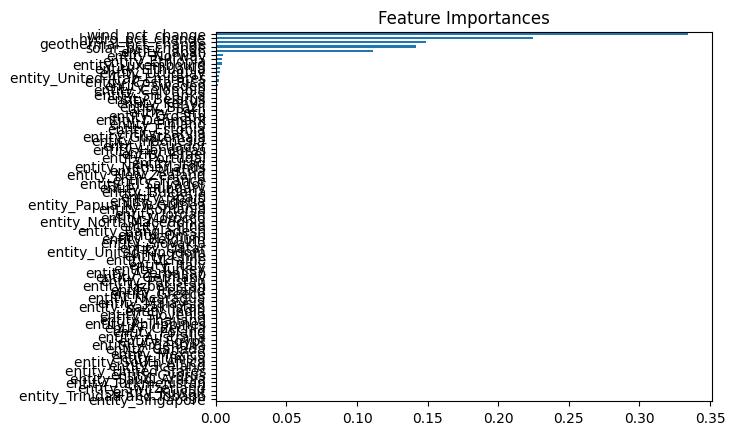

In [69]:
 #Fit a RandomForest model to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_preproc, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train_preproc.columns)
feature_importances.sort_values().plot(kind='barh', title="Feature Importances")
plt.show()

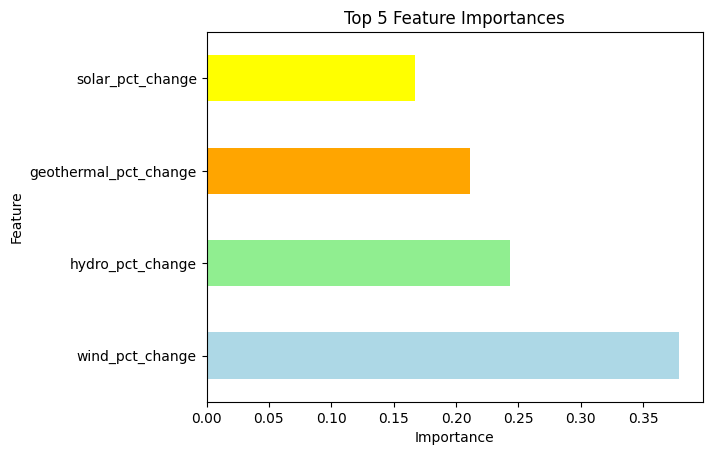

In [70]:
# Drop 'entity' related features (all columns with 'entity_') to remove noise
X_train_preproc_reduced = X_train_preproc.drop(columns=[col for col in X_train_preproc.columns if 'entity_' in col])

# Fit the model again after removing these columns
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_preproc_reduced, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train_preproc_reduced.columns)

# Sort and get the top 10 most important features
top_features = feature_importances.sort_values(ascending=False).head(5)

# Define color mapping for renewable energy types
color_mapping = {
    'solar_pct_change': 'yellow',
    'wind_pct_change': 'lightblue',
    'hydro_pct_change': 'lightgreen',
    'biomass_pct_change': 'brown',
    'geothermal_pct_change': 'orange',
    # Add more mappings if needed
}

# Map colors based on feature names
colors = [color_mapping.get(feature, 'gray') for feature in top_features.index]

# Plot the top 10 most important features with colors
top_features.plot(kind='barh', color=colors, title="Top 5 Feature Importances")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()        #what can I add to this plot to make the chart border rounded

**Features and Target selection: Second models training without Entity**

In [71]:
# Features and target
X = df[['wind_pct_change', 'hydro_pct_change','solar_pct_change', 'geothermal_pct_change']]
y = df['fossil_pct_change']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Define Function to evaluate 4 distinct models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Linear Regression
model_linear = LinearRegression()
mse_linear, mae_linear, r2_linear = evaluate_model(model_linear, X_train, X_test, y_train, y_test)

# Random Forest
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
mse_rf, mae_rf, r2_rf = evaluate_model(model_rf, X_train, X_test, y_train, y_test)

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=50, random_state=42)
mse_gb, mae_gb, r2_gb = evaluate_model(model_gb, X_train, X_test, y_train, y_test)

# XGBoost
model_xgb = XGBRegressor(n_estimators=50, random_state=42)
mse_xgb, mae_xgb, r2_xgb = evaluate_model(model_xgb, X_train, X_test, y_train, y_test)

# Output the results for all models
print(f"Linear Regression - MSE: {mse_linear}, MAE: {mae_linear}, R2: {r2_linear}")
print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"Gradient Boosting - MSE: {mse_gb}, MAE: {mae_gb}, R2: {r2_gb}")
print(f"XGBoost - MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")

Linear Regression - MSE: 2.671487704881412, MAE: 0.3796179043317895, R2: -4.956091101137463
Random Forest - MSE: 0.39894571730155504, MAE: 0.16982775466082836, R2: 0.11054913997361171
Gradient Boosting - MSE: 0.34058378430872327, MAE: 0.1424803208403196, R2: 0.2406672719450319
XGBoost - MSE: 0.27229260872128735, MAE: 0.13757918469985794, R2: 0.392922684709733


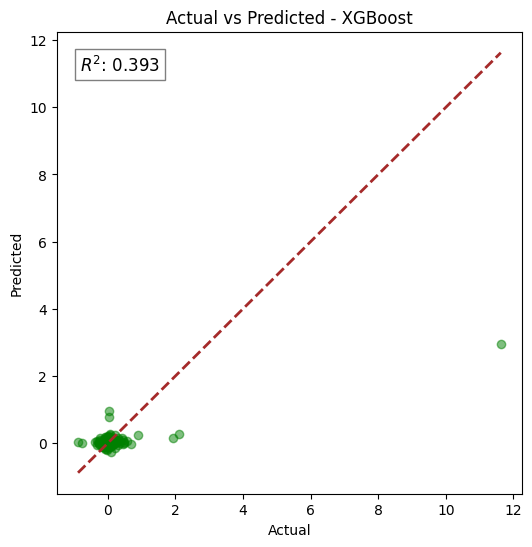

In [73]:
# Function to plot actual vs predicted values for XGBoost and display R² value
def plot_actual_vs_predicted_xgb(y_test, y_pred, r2_value):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='green')  # Green data points
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='brown', linestyle='--', lw=2)  # Yellow regression line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted - XGBoost")

    # Display R² value on the plot
    plt.text(0.05, 0.95, f'$R^2$: {r2_value:.3f}', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Get predictions for XGBoost model
y_pred_xgb = model_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)  # Calculate R² for XGBoost

# Plot for XGBoost model
plot_actual_vs_predicted_xgb(y_test, y_pred_xgb, r2_xgb)

In [74]:
df.to_csv('pct_changes_rwe_capacity.csv', index=False)

Key Conclusions

while our model provides valuable predictions to guide renewable energy investment, broader factors, such as such as economic, political, or technological factors, should be considered for a fuller understanding of fossil fuel reliance reduction.